# Segmentation of tissue using APOC segmentation GPU-accelerated supervised ML algorithm, utilizing manual annotation

- APOC object segmentation: https://github.com/haesleinhuepf/apoc/blob/main/demo/demo_object_segmenter.ipynb
- Depending on the GPU available, segmentations might run slow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import apoc
import pyclesperanto_prototype as cle
import napari
import tifffile

/home/natalia/miniconda3/envs/axolotl_limb_regeneration_s/lib/python3.11/site-packages/pytools/persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


In [2]:
from image_analysis.read_files import get_paths, change_paths

# GPU device

In [3]:
device = cle.get_device()
print("Device name:", device.name)

Device name: NVIDIA GeForce RTX 4090


# Information about the image

In [4]:
channels = {
            "fgf":    0, 
            "shh":    1, 
            "bright": 2, 
            "dapi":   3, 
            "dusp":   4, 
            "auto":   5
           }

# Fixed values for image preprocessing

In [5]:
downsample = 2                 # downsampling level while image loading (the same along all axis)

# Load image

In [6]:
image_folder_tif = r'example_raw_images/'
sample = '2_5cm_7dpa_noif'

img_paths = get_paths(image_folder_tif, channel='7d', suffix='tif')
img_paths = change_paths(img_paths, include='noif')

In [7]:
img_paths = sorted(
    img_paths,
    key = lambda c: c.split('/c')[1].split('_')[0]
)

In [8]:
img_paths

['example_raw_images/c1_hcr21_20240726_7d_noif_t4a#18.tif',
 'example_raw_images/c2_hcr21_20240726_7d_noif_t4a#18.tif',
 'example_raw_images/c3_hcr21_20240726_7d_noif_t4a#18.tif',
 'example_raw_images/c4_hcr21_20240726_7d_noif_t4a#18.tif',
 'example_raw_images/c5_hcr21_20240726_7d_noif_t4a#18.tif',
 'example_raw_images/c6_hcr21_20240726_7d_noif_t4a#18.tif']

In [9]:
img = []
for path in img_paths:
    i = tifffile.imread(path)
    img.append(i[::downsample, ::downsample, ::downsample])
img = np.array(img).astype( np.uint16 )

channels = list(channels.keys())
img = dict(zip(channels, img))

# Segmenter for tissue mask

In [10]:
manual_annotations = tifffile.imread('segmenters/manual_annotations_for_tissue_mask.tif')

In [11]:
# define features (standart)
features = apoc.PredefinedFeatureSet.small_quick.value

# this is where the model will be saved
cl_filename = "segmenters/tissue_mask_2_5cm.cl"

apoc.erase_classifier(cl_filename)
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)
clf.train(features, manual_annotations, img['dusp'])

4 warnings generated.
/home/natalia/miniconda3/envs/axolotl_limb_regeneration_s/lib/python3.11/site-packages/pyclesperanto_prototype/_tier9/_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


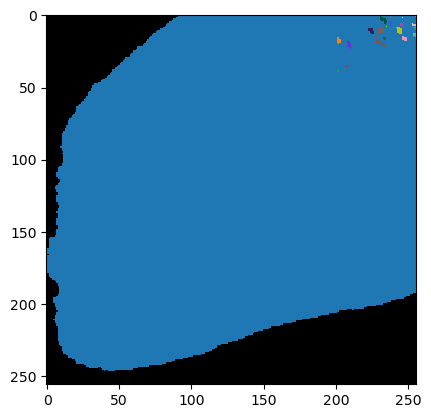

In [12]:
segmentation_result = clf.predict(features=features, image=img['dusp'])
cle.imshow(segmentation_result, labels=True)

# Segmenter for artifacts

In [13]:
manual_annotations = tifffile.imread('segmenters/manual_annotations_for_artifacts.tif')

In [14]:
# define features (standart)
features = apoc.PredefinedFeatureSet.small_quick.value

# this is where the model will be saved
cl_filename = "segmenters/artifacts_2_5cm.cl"

apoc.erase_classifier(cl_filename)
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)
clf.train(features, manual_annotations, img['auto'])

4 warnings generated.
/home/natalia/miniconda3/envs/axolotl_limb_regeneration_s/lib/python3.11/site-packages/pyclesperanto_prototype/_tier9/_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


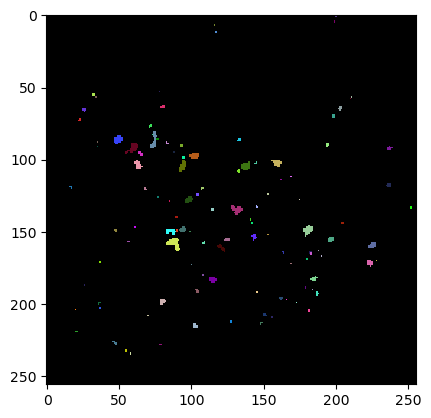

In [15]:
segmentation_result = clf.predict(features=features, image=img['auto'])
cle.imshow(segmentation_result, labels=True)